<a href="https://colab.research.google.com/github/Alisoltan82/whole_body_seg/blob/main/wholebody_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
!pip install monai
!pip install tcia_utils

In [ ]:
!pip install nibabel
import nibabel as nib

In [ ]:
import os
import numpy as np
import torch
import pydicom
import cv2
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose , Resized , Resize , ToTensor , ToTensord
#from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [ ]:
from glob import glob

In [ ]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [ ]:
datadir = os.path.join(HOME , 'Data')
datadir

'/kaggle/working/Data'

In [ ]:
# https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-57651705005866257

In [ ]:
# cart_name = "nbia-56561691129779503"
# cart_data = nbia.getSharedCart(cart_name)
# df = nbia.downloadSeries(cart_data, format="df", path = datadir)

In [ ]:
CT_folder = os.path.join(datadir, '/kaggle/working/Data/1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')
CT_folder
out_path = '/kaggle/working'

In [ ]:
!pip install dicom2nifti
import dicom2nifti

In [ ]:
dicom2nifti.dicom_series_to_nifti(CT_folder , os.path.join(out_path , 'one.nii.gz') , reorient_nifti=True )

In [ ]:
sample = nib.load('/kaggle/working/one.nii.gz').get_fdata()
sample.shape

(512, 512, 975)

In [ ]:
# !wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/monaitoolkit/monai_wholebody_ct_segmentation/versions/0.1.9/zip -O monai_wholebody_ct_segmentation_0.1.9.zip

We first set the paths of where we downloaded the model parameters (`model.pt`) and a file called `inference.json`.

In [ ]:
# from zipfile import ZipFile

# file_path = "//kaggle/working/monai_wholebody_ct_segmentation_0.1.9.zip"

# # opening the zip file in READ mode
# with ZipFile(file_path, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall('./Model')
#     print('Done!')

In [ ]:
model_path = os.path.join(datadir, '/kaggle/working/Model/models/model_lowres.pt')
config_path = os.path.join(datadir, '/kaggle/input/infer1000/inference (7).json')

In [ ]:
config = ConfigParser()
config.read_config(config_path)

In [ ]:
preprocessing = config.get_parsed_content("preprocessing")

In [ ]:
device = torch.device('cpu')

In [ ]:
model = config.get_parsed_content("network").to(device)

In [ ]:
data = preprocessing({'image': '/kaggle/working/one.nii.gz'})

In [ ]:
model.load_state_dict(torch.load(model_path , map_location= torch.device('cpu')))

model.eval();

In [ ]:
inferer = config.get_parsed_content("inferer")

In [ ]:
postprocessing = config.get_parsed_content("postprocessing")

In [ ]:
data['image'].unsqueeze(0).shape

torch.Size([1, 1, 167, 167, 650])

In [ ]:
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]


In [ ]:
data['image'].shape , data['pred'].shape

(torch.Size([167, 167, 650]), torch.Size([105, 167, 167, 650]))

In [ ]:
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

2024-01-14 18:50:17,117 INFO image_writer.py:197 - writing: eval/one/one_trans.nii.gz


In [ ]:
segment = data['pred'][0]

In [ ]:
slice_idx = 200
images = nib.load('/kaggle/working/one.nii.gz').get_fdata()

CT_coronal_slice = images[:,slice_idx , :]
segmentation_coronal_slice = segment[:,slice_idx , :]

In [ ]:
images.shape

(512, 512, 975)

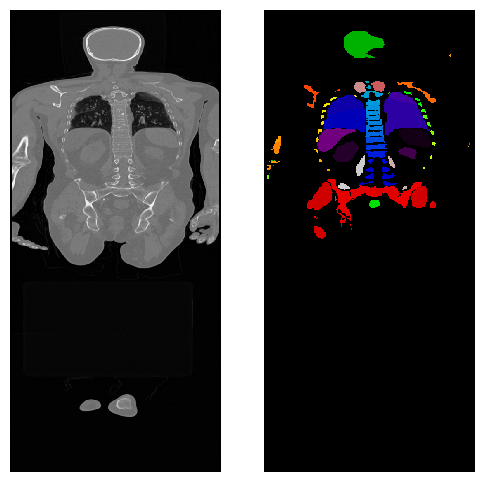

In [ ]:
plt.subplots(1,2,figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

The mask can be used for many purposes
* Radiotherapy planning to avoid certain organs
* (My research) utilization in SPECT/PET reconstruction algorithms to improve quantitation
* Compute organ volumes

**Example**: Computing bladder volume

In [ ]:
number_bladder_voxels = (segmentation==13).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')